In [5]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
#import external pandas_datareader library with alias of web
from pandas_datareader import data as pdr
#import datetime internal datetime module
#datetime is a Python module
import datetime
import fix_yahoo_finance
import matplotlib.pyplot as plt2
from keras.layers.advanced_activations import LeakyReLU


sys.path
sys.executable
print("Import all useful modules")

/Users/zhen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Import all useful modules


Get the tesla price data from Yahoo finance as a CSV.

In [6]:
def get_stock_data():   
    data = pdr.get_data_yahoo('TSLA', start='2017-01-15', end='2019-03-08')
#datetime.datetime is a data type within the datetime module
    cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
    data.reindex(columns=cols)

#invoke to_csv for df dataframe object from 
#DataReader method in the pandas_datareader library
 
#..\first_yahoo_prices_to_csv_demo.csv must not
#be open in another app, such as Excel
    data.to_csv('tesla.csv')
    return data
    


In [7]:

data = get_stock_data()
print(data)

                  High         Low        Open       Close    Volume  \
Date                                                                   
2017-01-17  239.960007  234.369995  236.699997  235.580002   4611900   
2017-01-18  239.710007  235.580002  236.649994  238.360001   3769000   
2017-01-19  248.679993  240.750000  247.250000  243.759995   7732300   
2017-01-20  246.000000  243.009995  245.460007  244.729996   4204300   
2017-01-23  250.889999  245.500000  245.850006  248.919998   6262900   
2017-01-24  254.800003  249.649994  250.000000  254.610001   4965500   
2017-01-25  258.459991  251.800003  257.309998  254.470001   5142600   
2017-01-26  255.740005  250.750000  254.289993  252.509995   3152100   
2017-01-27  253.000000  248.520004  251.380005  252.949997   3166300   
2017-01-30  255.289993  247.100006  252.529999  250.630005   3801100   
2017-01-31  255.889999  247.699997  249.240005  251.929993   4116100   
2017-02-01  253.199997  249.050003  253.050003  249.240005   395

Take a look at the data we got, it contains date, open price, high, low, close price, volumn and adjusted-close price

In [8]:
df = data[['Open', 'High','Volume','Close']].astype(float)
y = data['Close'].astype(float)
print(y)


Date
2017-01-17    235.580002
2017-01-18    238.360001
2017-01-19    243.759995
2017-01-20    244.729996
2017-01-23    248.919998
2017-01-24    254.610001
2017-01-25    254.470001
2017-01-26    252.509995
2017-01-27    252.949997
2017-01-30    250.630005
2017-01-31    251.929993
2017-02-01    249.240005
2017-02-02    251.550003
2017-02-03    251.330002
2017-02-06    257.769989
2017-02-07    257.480011
2017-02-08    262.079987
2017-02-09    269.200012
2017-02-10    269.230011
2017-02-13    280.600006
2017-02-14    280.980011
2017-02-15    279.760010
2017-02-16    268.950012
2017-02-17    272.230011
2017-02-21    277.390015
2017-02-22    273.510010
2017-02-23    255.990005
2017-02-24    257.000000
2017-02-27    246.229996
2017-02-28    249.990005
                 ...    
2019-01-25    297.040009
2019-01-28    296.380005
2019-01-29    297.459991
2019-01-30    308.769989
2019-01-31    307.019989
2019-02-01    312.209991
2019-02-04    312.890015
2019-02-05    321.350006
2019-02-06    317.22


Normalizing

In [9]:
def standard(l):
    maxx = max(l)
    minn = min(l)
    #print("maxx",maxx)
    #print("minn",minn)
    l = (l-minn)/(maxx-minn)
    return l
    

In [10]:

df['Open'] = standard(df['Open'])
df['High'] = standard(df['High'])
df['Volume'] = standard(df['Volume'])
df['Close'] = standard(df['Close'])

maxx = float(max(y))
minn = float(min(y))
print(maxx)
print(minn)




385.0
235.5800018310547


In [24]:
#Load the data
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    print(amount_of_features)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    #print(result.shape)
    row = round(0.7 * result.shape[0])
    #print("row",row)
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]
    
    #print(x_train.shape)
    #print(y_train)
    #print(x_test.shape)
    print(y_test)
    
    # reshape input to be [samples, time steps, features]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [25]:
#Build the model
def build_model(layers):
    model = Sequential()
    model.add(LSTM(200, activation='tanh', input_shape=(layers[0], layers[1])))
    model.add(Dropout(0.2))
    
    model.add(LSTM(200, activation='tanh', input_shape=(layers[0],layers[1],layers[2]),return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='rmsprop',metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model


def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='tanh'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='tanh'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

split train and test dataset

In [61]:
window = 5
trainX, trainY, testX, testY = load_data(df[::-1], window)
#print("X_train", X_train.shape)
#print("y_train", y_train.shape)
#print("X_test", X_test.shape)
#print("y_test", y_test.shape)
#print(X_train)



4
[0.76301697 0.80190064 0.80524691 0.78704318 0.74809252 0.73671532
 0.7527104  0.78537005 0.78429921 0.70787047 0.68451335 0.74876182
 0.77861071 0.85216171 0.84827992 0.85811797 0.81843123 0.80190064
 0.85631106 0.86762148 0.80036148 0.81200645 0.74628561 0.60440379
 0.56210686 0.58820774 0.6658413  0.66175874 0.72460183 0.69615852
 0.71570063 0.62120194 0.63137473 0.60018745 0.6201311  0.56210686
 0.61705259 0.5878062  0.62869755 0.61330478 0.53854897 0.51960916
 0.49022879 0.61243472 0.78329537 0.84346128 0.83770579 0.90791052
 0.84854768 0.94973892 0.98962664 0.98400472 0.94244408 0.91460307
 0.89827324 0.90898135 0.93534999 0.97095438 0.93943255 0.82606083
 0.81475041 0.89961183 0.83034395 0.78483473 0.74782497 0.69783165
 0.7013117  0.70559503 0.66604207 0.59938438 0.54376915 0.49953152
 0.45696683 0.50040159 0.50361388 0.51853833 0.47202506 0.54497396
 0.53741135 0.59717572 0.58573153 0.59991969 0.57341727 0.47925312
 0.4870165  0.4007495  0.50488548 0.55755598 0.58392441 0.52

In [83]:
model = build_model2([4,window,1])
model.fit( trainX,trainY,batch_size=512,epochs=20,validation_split=0.1,verbose=1)


Train on 335 samples, validate on 38 samples
Epoch 1/20
335/335 [==============================] - 4s 13ms/step - loss: 0.3263 - acc: 0.0000e+00 - val_loss: 0.6169 - val_acc: 0.0000e+00
Epoch 2/20
335/335 [==============================] - 0s 124us/step - loss: 0.3237 - acc: 0.0000e+00 - val_loss: 0.6111 - val_acc: 0.0000e+00
Epoch 3/20
335/335 [==============================] - 0s 120us/step - loss: 0.3201 - acc: 0.0000e+00 - val_loss: 0.6053 - val_acc: 0.0000e+00
Epoch 4/20
335/335 [==============================] - 0s 115us/step - loss: 0.3166 - acc: 0.0000e+00 - val_loss: 0.5990 - val_acc: 0.0000e+00
Epoch 5/20
335/335 [==============================] - 0s 117us/step - loss: 0.3129 - acc: 0.0000e+00 - val_loss: 0.5920 - val_acc: 0.0000e+00
Epoch 6/20
335/335 [==============================] - 0s 123us/step - loss: 0.3086 - acc: 0.0000e+00 - val_loss: 0.5839 - val_acc: 0.0000e+00
Epoch 7/20
335/335 [==============================] - 0s 119us/step - loss: 0.3036 - acc: 0.0000e+00 - v

In [84]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.07 MSE (0.27 RMSE)
Test Score: 0.07 MSE (0.27 RMSE)


                     0
Date                  
2018-07-19  294.552460
2018-07-20  293.645874
2018-07-23  292.696442
2018-07-24  293.074341
2018-07-25  293.216400
2018-07-26  293.530029
2018-07-27  293.498474
2018-07-30  293.203644
2018-07-31  292.760895
2018-08-01  292.585632
2018-08-02  292.815338
2018-08-03  293.056763
2018-08-06  292.880615
2018-08-07  292.481842
2018-08-08  292.484344
2018-08-09  293.399475
2018-08-10  294.360291
2018-08-13  294.948059
2018-08-14  295.190735
2018-08-15  295.209534
2018-08-16  295.281830
2018-08-17  295.141449
2018-08-20  295.440826
2018-08-21  295.408020
2018-08-22  294.782043
2018-08-23  293.654572
2018-08-24  292.670135
2018-08-27  291.145599
2018-08-28  289.393463
2018-08-29  289.752289
...                ...
2019-01-25  257.886597
2019-01-28  258.443756
2019-01-29  258.459839
2019-01-30  258.783142
2019-01-31  259.289764
2019-02-01  260.353333
2019-02-04  261.803894
2019-02-05  264.735992
2019-02-06  267.861176
2019-02-07  270.576385
2019-02-08 

<Figure size 1440x720 with 0 Axes>

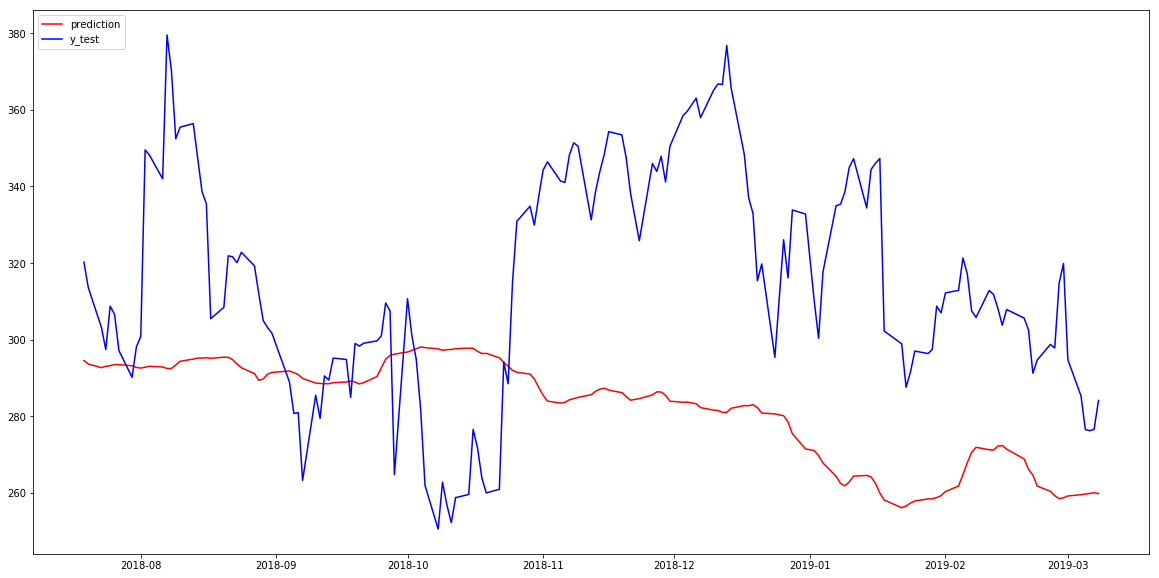

In [88]:
          
prediction = model.predict(testX,verbose=0)

#print(prediction)
ind = y.index[-len(testY):]

Y_pred = pd.DataFrame(prediction*(maxx-minn)+minn)
Y_pred.set_index(ind, inplace=True, drop=True)

Y_act = pd.DataFrame(y[-len(testY):])
Y_act.set_index(ind, inplace=True, drop=True)
print(Y_pred)
plt2.figure(figsize=(20,10))
plt2.plot(Y_pred,color='red', label='prediction')
plt2.plot(Y_act,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

